# Project: Multiple Regression Analysis for Beer Ratings

### Kate Grosch and Lucas Baker

We would like to determine whether factors such as ABV, reviewer age, and beer appearance contribute to the overall rating of a beer, using data from online craft beer ratings.

To begin our analysis, we will load the project packages and the dataset.

In [1]:
# loading the packages and modules

%matplotlib inline

# general packages
import numpy as np
import pandas as pd
import sklearn
from collections import defaultdict

# for statistics
import scipy.stats as stats
import statsmodels.api as sm

# for visualizations
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

### Important Notes about the Data

We do some basic data cleaning below: We remove ABV values outside of 3 standard deviations from the mean (to remove some junk ABV values we had) and we remove rows without a valid reviewer gender and age. 

In [2]:
#loading and cleaning the data

df = pd.read_csv("beer.csv")

df = df.rename(index=str, columns={'beer/ABV': 'ABV', 
                                   'user/gender':'gender', 
                                   'user/ageInSeconds':'reviewerAgeInSeconds', 
                                   'review/overall':'overall', 
                                   'beer/beerId':'beerId', 
                                   'beer/brewerId':'brewerId', 
                                   'review/appearance':'appearance', 
                                   'review/aroma':'aroma', 
                                   'review/palate':'palate', 
                                   'review/taste':'taste', 
                                   'review/timeUnix': 'unixPostTime'})

df = df[np.abs(df.ABV-df.ABV.mean()) <= (3*df.ABV.std())]
df = df[df.reviewerAgeInSeconds.notnull()]
df = df[df.gender.notnull()]

Y = df['overall']
df = df.drop(['review/text', 
              'review/timeStruct',
              'user/birthdayRaw',
              'user/birthdayUnix',
              'index',
              'beer/style', 
              'user/profileName'], axis=1)

df.describe()


,ABV,beerId,brewerId,appearance,aroma,overall,palate,taste,unixPostTime,reviewerAgeInSeconds
count,7704.000000,7704.000000,7704.000000,7704.000000,7704.000000,7704.000000,7704.000000,7704.000000,7.704000e+03,7.704000e+03
mean,7.454991,21805.936397,3068.560618,3.912318,3.897326,3.912059,3.866498,3.952687,1.236645e+09,1.167445e+09
std,2.272365,18540.411751,5187.312029,0.590726,0.671394,0.698766,0.668260,0.714050,6.573249e+07,3.088040e+08
min,0.500000,175.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.932515e+08,7.034366e+08
25%,5.500000,5441.000000,395.000000,3.500000,3.500000,3.500000,3.500000,3.500000,1.198043e+09,9.775586e+08
50%,7.000000,18968.000000,1199.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.248133e+09,1.096639e+09
75%,9.400000,34146.000000,1315.000000,4.500000,4.500000,4.500000,4.500000,4.500000,1.289380e+09,1.274541e+09
max,14.000000,77207.000000,26990.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.326257e+09,3.594723e+09


### Model and Variables

Our full list of variables is ABV, brewer, appearance rating, aroma rating, palate rating, taste rating, review submission date, reviewer age, and reviewer gender. We got this dataset from Kaggle, and the CSV is available at https://github.com/katiegrosch/beer-data-analysis.

Before performing the analysis, we will PEprocess the data to extract our explanatory features. Our desired y and x<sub>i</sub>'s are as follows:

y: Overall rating, on a range of [1.0, 5.0]. <br>
x<sub>1</sub> The number of reviews for the beer. <br>
x<sub>2</sub> Average reviewer age. <br>
x<sub>3</sub> Fraction of female reviewers. <br>
x<sub>4</sub> Beer appearance rating, in the range [1.0, 5.0]. <br>
x<sub>5</sub> Alcohol by volume. <br>
x<sub>6</sub> Length of beer name. <br>

We will be modeling the impact of the x<sub>i</sub>'s on y in the form of the following multiple regression model, where &beta;<sub>i</sub>'s are constants fit by least squares regression:<br><br>
y = &beta;<sub>0</sub> + &beta;<sub>1</sub>x<sub>1</sub> + &beta;<sub>2</sub>x<sub>2</sub> + &beta;<sub>3</sub>x<sub>3</sub> + &beta;<sub>4</sub>x<sub>4</sub> + &beta;<sub>5</sub>x<sub>5</sub> + &beta;<sub>6</sub>x<sub>6</sub>

First, we will preprocess the data:

In [3]:
df['beerNameLength'] = pd.Series([len(x) for x in df['beer/name']], index=df.index)

beer_abv = dict()
beer_overall = defaultdict(list)
beer_appearance = defaultdict(list)
reviewer_ages = defaultdict(list)
reviewer_genders = defaultdict(list)
for index, row in df.iterrows():
    name = row['beer/name']
    beer_abv[name] = row['ABV']  # Will overwrite, but same values
    beer_overall[name].append(row['overall'])
    beer_appearance[name].append(row['appearance'])
    reviewer_ages[name].append(row['reviewerAgeInSeconds'])
    reviewer_genders[name].append(0.0 if row['gender'].startswith("M") else 1.0)
names = sorted(set(df['beer/name']))
    
combined = {
    'beerName': names,
    'numReviews': [len(beer_overall[name]) for name in names],
    'ABV': [beer_abv[name] for name in names],
    'avgAppearance': [np.mean(beer_appearance[name]) for name in names],
    'avgReviewerAgeInYears': [np.mean(reviewer_ages[name]) / 31557600 for name in names],
    'fractionFemale': [np.mean(reviewer_genders[name]) for name in names],
    'beerNameLength': [len(name) for name in names],
    'avgOverall': [np.mean(beer_overall[name]) for name in names]
}

df = pd.DataFrame(combined)
df.describe()

,numReviews,ABV,avgAppearance,avgReviewerAgeInYears,fractionFemale,beerNameLength,avgOverall
count,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000
mean,10.123522,6.331905,3.678017,37.858362,0.011464,19.498029,3.676361
std,31.617209,1.984198,0.542341,8.498555,0.082130,9.081810,0.674804
min,1.000000,0.500000,1.000000,25.104959,0.000000,2.000000,1.000000
25%,1.000000,5.000000,3.500000,33.565032,0.000000,13.000000,3.500000
50%,2.000000,5.800000,3.762500,36.731424,0.000000,18.000000,3.825000
75%,5.000000,7.500000,4.000000,40.583455,0.000000,25.000000,4.000000
max,408.000000,14.000000,5.000000,113.488258,1.000000,72.000000,5.000000


To begin our analysis, let's look at a graph of every x<sub>i</sub> versus our target variable (overall rating).

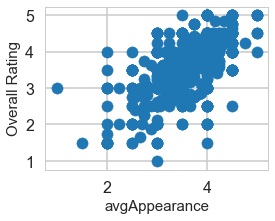

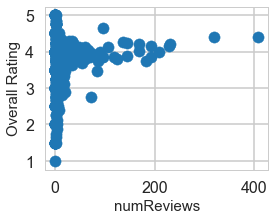

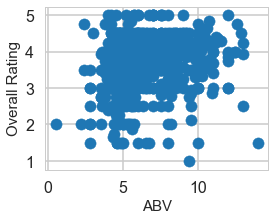

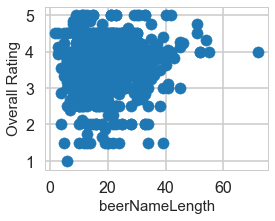

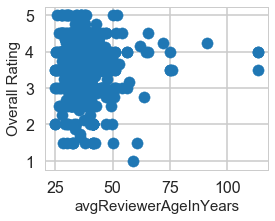

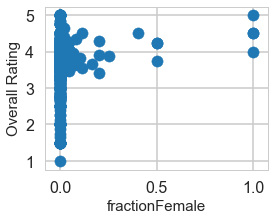

In [11]:
Y = df['avgOverall']
ratings = df.drop(['avgOverall', 'beerName'], axis=1)

# plt.figure(figsize=(4, 3))
# plt.scatter(ratings['avgAppearance'], Y)
# plt.ylabel('Overall Rating', size=15)
# plt.xlabel('Average Appearance', size=15)

for column in ['avgAppearance', 'numReviews', 'ABV', 'beerNameLength', 'avgReviewerAgeInYears', 'fractionFemale']:
    plt.figure(figsize=(4, 3))
    plt.scatter(ratings[column], Y)
    plt.ylabel('Overall Rating', size=15)
    plt.xlabel(column, size=15)

### Variable Correlations

Visually speaking, there appears to be a fairly strong correlation between appearance rating and overall rating, as might be expected. Number of reviews also appears to be at least somewhat linked to quality: while there are many beers with few reviews at all levels, most of the highly rated beers are above 4, relative to a mean average overall rating of 3.67. The other explanatory variables seem to have a more tenuous connection. Plots for ABV, beer name length, and average reviewer age in years appear as a fairly undifferentiated mass, and while it is clear that female reviewers give a higher rating on average, the average fraction of female viewers is 1.1%! Detecting a strong effect on such a lopsided distribution will be difficult.

Let's also see if any of the variables correlate with each other. This could help us mitigate unnecessary variance in our regression's beta values.

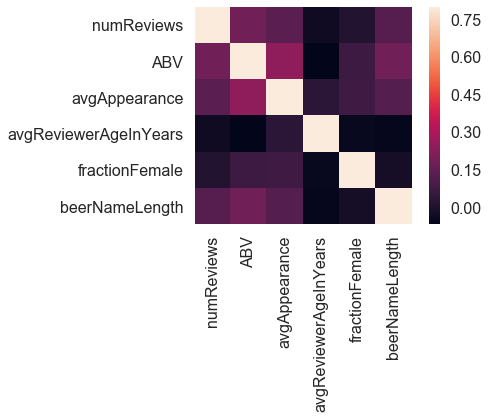

In [12]:
corrmat = ratings.corr()
sns.heatmap(corrmat, vmax=.8, square=True);


### Variable correlations in the heatmap

In the confusion matrix above, lighter colors imply higher correlation. Trivially, each variable has a perfect correlation with itself. We can confirm that none of these variables correlate strongly with one another, which is reasonable given the idiosyncratic choice of regressors. However, ABV and appearance rating show at least a weak relationship, which may suggest a correlation between ABV, appearance, and a third variable such as style. (For example, an Imperial Stout might tend to be both stronger and darker in color.)

Before we create our regression model, let's just look at a histogram of the ratings to get a sense of where they cluster. It looks like the ratings are skewed somewhat, but overall have a normal distribution. We confirm the skew by calculating the skew of the data to be -0.9947. That might affect our model.

Skew: -0.994747


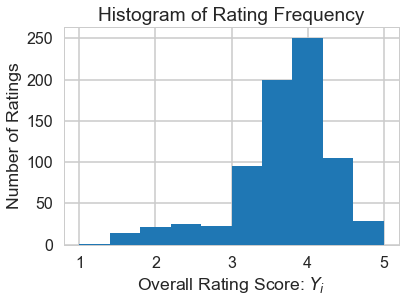

In [13]:
plt.hist(Y)
plt.xlabel("Overall Rating Score: $Y_i$")
plt.ylabel("Number of Ratings")
plt.title("Histogram of Rating Frequency")

print("Skew: %f" % Y.skew())

### Building the Linear Regression

(646, 6)
(646,)
(115, 6)
(115,)


Text(0.5,1,'Ratings vs Predicted ratings: $Y_i$ vs $\\hat{Y}_i$')

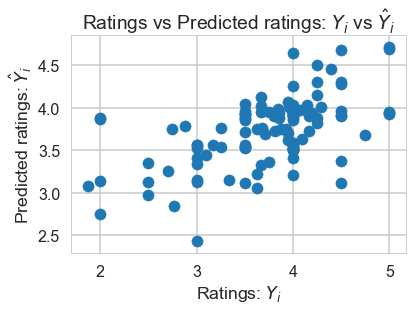

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ratings, Y, test_size=.15, random_state=10)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel("Ratings: $Y_i$")
plt.ylabel("Predicted ratings: $\hat{Y}_i$")
plt.title("Ratings vs Predicted ratings: $Y_i$ vs $\hat{Y}_i$")

In [15]:
from sklearn.metrics import mean_squared_error

print("Mean Squared Error: %f" % mean_squared_error(y_test, y_pred))
print("R squared: %f" % lr.score(ratings, Y))
print("Beta coefficients: ")
print(lr.coef_)
print("Largest coefficient: %f" % np.amax(lr.coef_))

Mean Squared Error: 0.285410
R squared: 0.381342
Beta coefficients: 
[ 5.29986753e-04  4.50481868e-03  7.51164853e-01 -5.06674217e-03
  5.53689830e-01 -3.20003279e-05]
Largest coefficient: 0.751165
